Training

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
import cv2
import os
from tqdm import tqdm
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization




In [6]:
# Specify the paths to your train and test directories
train_dir = '/kaggle/input/newdatasettrain/train'
test_dir = '/kaggle/input/newdatatest/test'

# Define the list of emotions or labels
labels = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


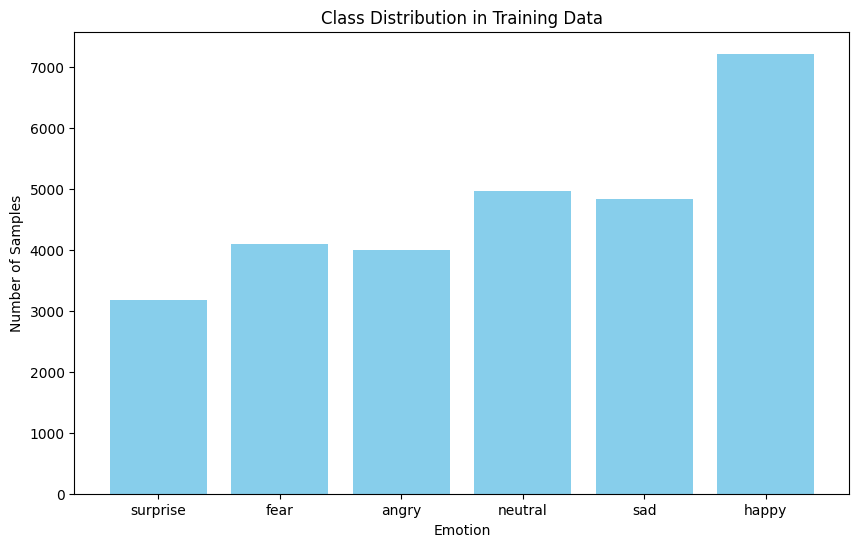

In [7]:


# Get the list of class directories
class_directories = os.listdir(train_dir)

# Dictionary to store class distribution
class_distribution = {}

# Count the number of images in each class
for class_dir in class_directories:
    class_path = os.path.join(train_dir, class_dir)
    num_images = len(os.listdir(class_path))
    class_distribution[class_dir] = num_images

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.title('Class Distribution in Training Data')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.show()


In [8]:
# Training data variables
X_train = []
Y_train = []

# Validation data variables
X_valid = []
Y_valid = []

# Load training data
for label in labels:
    folderpath = os.path.join(train_dir, label)
    for file in os.listdir(folderpath):
        img_path = os.path.join(folderpath, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        X_train.append(np.array(img))
        Y_train.append(labels.index(label))

# Load validation data
for label in labels:
    folderpath = os.path.join(test_dir, label)
    for file in os.listdir(folderpath):
        img_path = os.path.join(folderpath, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        X_valid.append(np.array(img))
        Y_valid.append(labels.index(label))

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

In [9]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Convert labels to categorical format using one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(labels))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(labels))

# Print the shapes of the arrays
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (22618, 224, 224, 3) (22618, 6)
Testing data shape: (5655, 224, 224, 3) (5655, 6)


# ResNet50-based model

In [10]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=6,
                   weights='imagenet')                  #resnet er model use korsi 
                                                        #with imagenet er upor kora weight e
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(6, activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [12]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
history_2 = resnet_model.fit(
        X_train,y_train,
        epochs=20,
        validation_data=(X_test,y_test))  

Epoch 1/20


I0000 00:00:1707076156.563465     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


707/707 [==============================] - 91s 117ms/step - loss: 1.3869 - accuracy: 0.4672 - val_loss: 1.2578 - val_accuracy: 0.5174
Epoch 2/20
707/707 [==============================] - 80s 113ms/step - loss: 1.2020 - accuracy: 0.5360 - val_loss: 1.2407 - val_accuracy: 0.5197
Epoch 3/20
707/707 [==============================] - 80s 113ms/step - loss: 1.1362 - accuracy: 0.5644 - val_loss: 1.1864 - val_accuracy: 0.5475
Epoch 4/20
707/707 [==============================] - 79s 112ms/step - loss: 1.0743 - accuracy: 0.5895 - val_loss: 1.1628 - val_accuracy: 0.5577
Epoch 5/20
707/707 [==============================] - 80s 113ms/step - loss: 1.0212 - accuracy: 0.6117 - val_loss: 1.2109 - val_accuracy: 0.5462
Epoch 6/20
707/707 [==============================] - 80s 113ms/step - loss: 0.9720 - accuracy: 0.6329 - val_loss: 1.1655 - val_accuracy: 0.5632
Epoch 7/20
707/707 [==============================] - 80s 113ms/step - loss: 0.9160 - accuracy: 0.6551 - val_loss: 1.1821 - val_accuracy: 0.5

221/221 [==============================] - 22s 98ms/step
Validation Accuracy :  0.5653035234187067


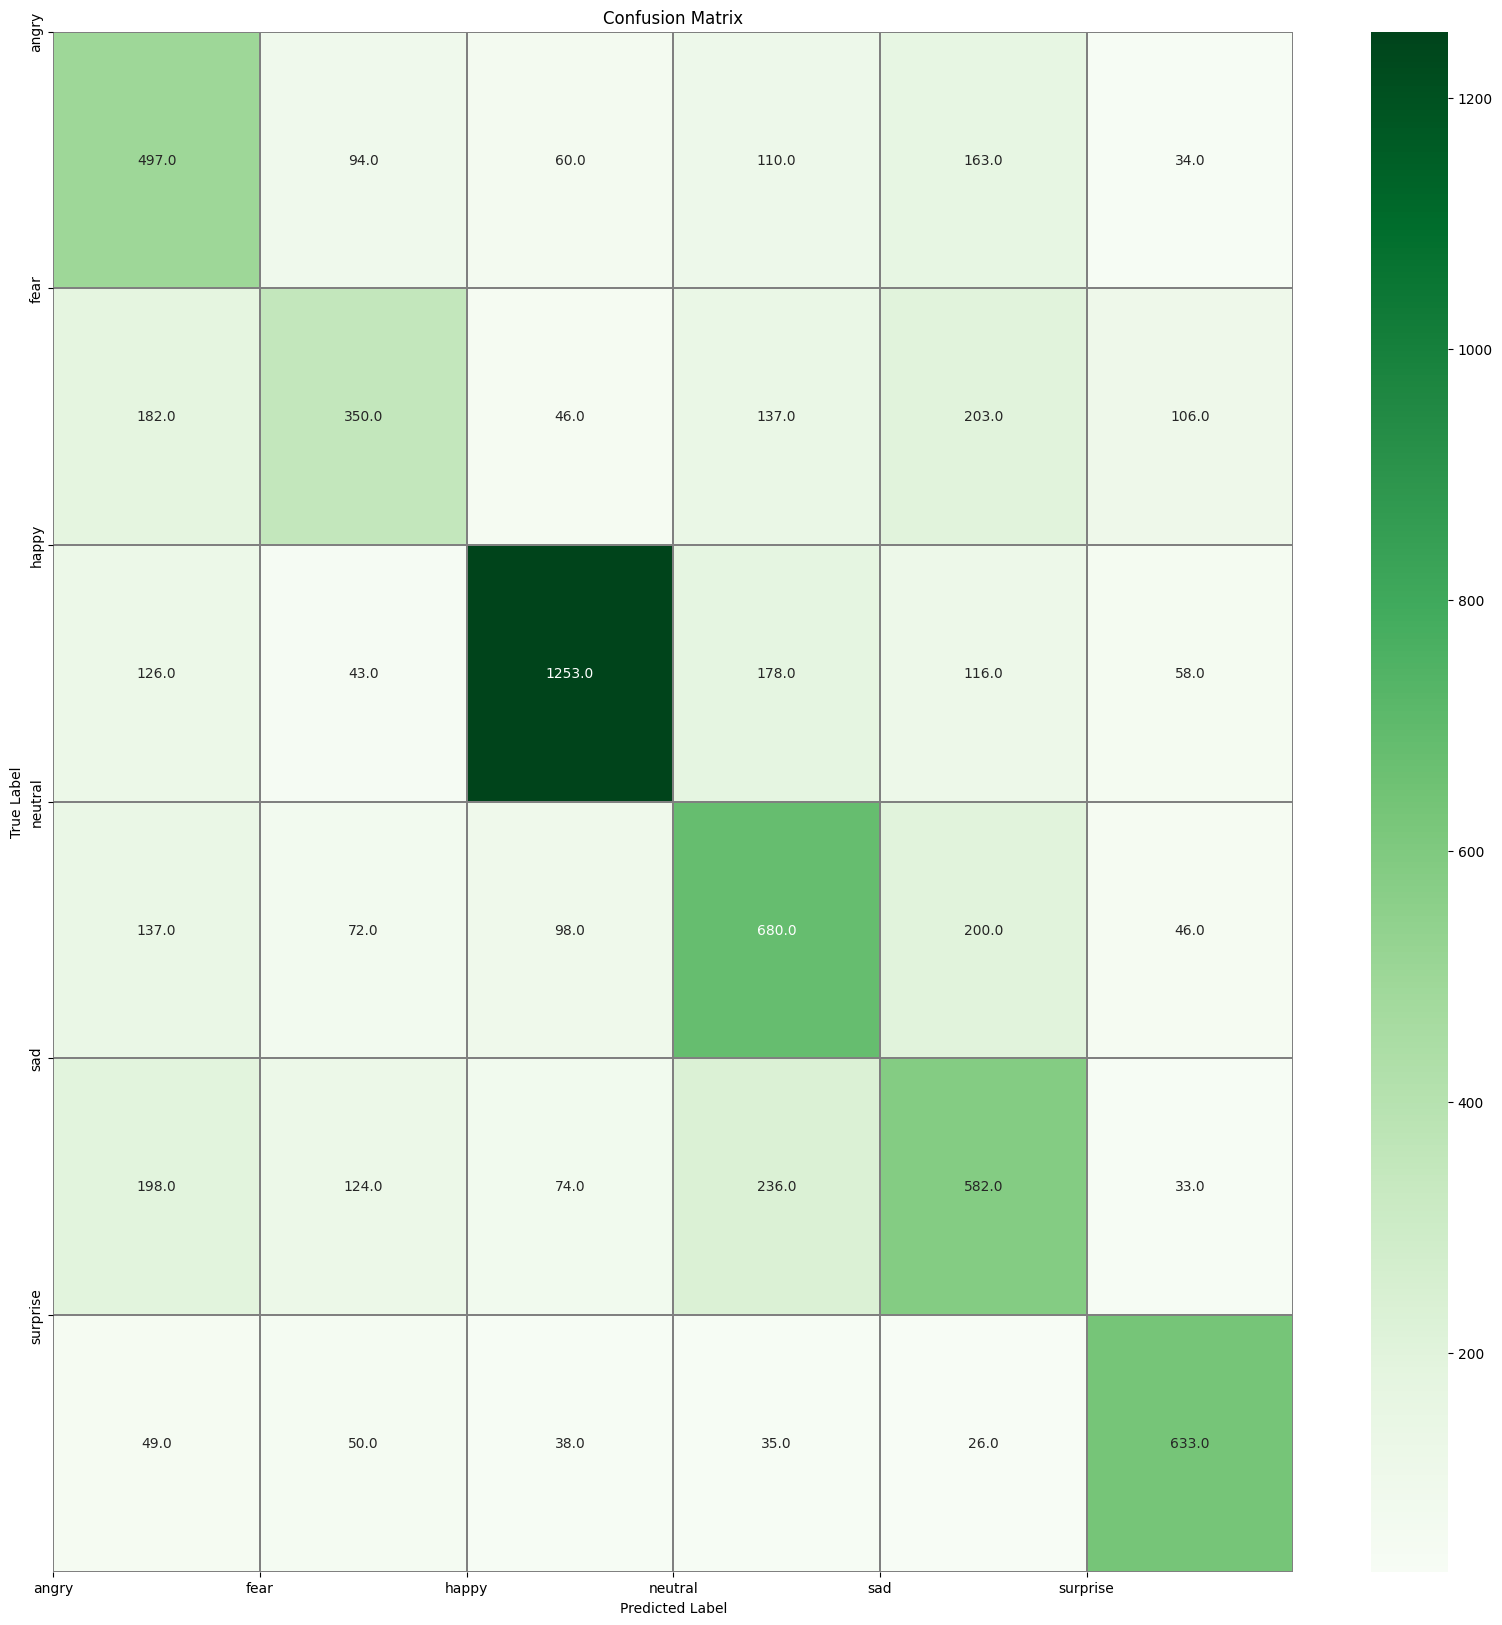

In [14]:
def conf_matrix(m, X, Y, class_labels):
    predictions = m.predict(X)
    y_pred = np.argmax(predictions, axis=1)
    
    print('Validation Accuracy : ', accuracy_score(Y, y_pred))
    
    cm = confusion_matrix(Y, y_pred)
    
    f, ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(cm, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='.1f', ax=ax)
    
    # Set tick labels on both axes
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))
    
    # Set the actual class labels as tick labels
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig("ConfMat.png")
    plt.show()

# Assuming your class labels are stored in the 'labels' variable
conf_matrix(resnet_model, X_valid, Y_valid, labels)
